# CAB420, DCNNs, Example 1: Classification with Deep Learning
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we will:
* Train a deep learning classifier to classify images
* Explore different layers, include fully connected and convoluational layers, and different activation functions

## Too Long; Didn't Read:
The main take home messages from this example are:
* We need to set out data up as the network expects it. That means that data and input shape must match, and for a classification network we need a categorical (one-hot vector) representation
* We can process images as a vector if we wish, but this disregards spatial information, and may not be the best approach to use.
* Convoluational networks allow us to learn over images (or other signals, as we'll see), and exploit spatial information
* Like other models, adding complexity for the sake of it may not always be for the best. Deep networks can overfit just like any other model

In [1]:
import os
import datetime
import numpy

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

### A note about versions

You may have already encoutered this with other packages for CAB420, but it's worth noting here that the version of package that you use is important. On my builds, I'm running at least version 1.0.0 for sklearn and 2.6.0 for tensorflow. Earlier versions may not run the code we have here (or more likley other examples, as this one is pretty straight forward). If you start getting weird errors, one of the first things you check should be what version of key packages you are running.

In [2]:
print(sklearn.__version__)
print(tf.__version__)

0.24.1
2.4.1


## The Data
We'll use FashionMNIST. This is a built in dataset within keras/tensorflow, so we can load it directly through the keras API. This will also download the data the first time this is run.

Initially, we'll do a simple network that using a couple of fully connected layers and see how that works. To get the data into the format that we need, we'll flatten the data into vectors.

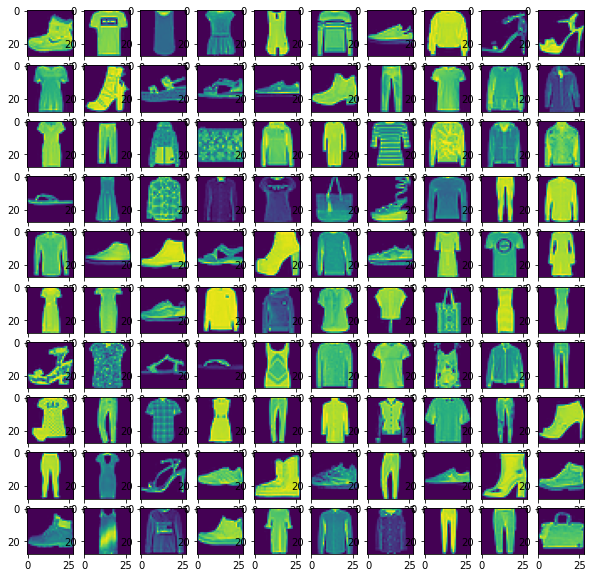

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train[i,:])
    
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

## Our First Model
We'll create a first neural network now. Throughout this example (and I suspect all others) I'm going to use the [functional API](https://keras.io/getting-started/functional-api-guide/) within Keras. This is not quite as simple as the [sequential models](https://keras.io/getting-started/sequential-model-guide/) within Keras, but it's far more powerful and it's still pretty easy to follow what's going on.

In [4]:
# create an input, we need to specify the shape of the input, in this case it's a vectorised images with a 784 in length
inputs = keras.Input(shape=(784,), name='img')
# first layer, a dense layer with 64 units, and a relu activation. This layer recieves the 'inputs' layer as it's input
x = layers.Dense(256, activation='relu')(inputs)
# second layer, another dense layer, this layer recieves the output of the previous layer, 'x', as it's input
x = layers.Dense(64, activation='relu')(x)
# output layer, length 10 units. This layer recieves the output of the previous layer, 'x', as it's input
outputs = layers.Dense(10, activation='softmax')(x)

# create the model, the model is a collection of inputs and outputs, in our case there is one of each
model = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_model')
# print a summary of the model
model.summary()

Model: "fashion_mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


For clarify, we'll also draw some pictures of the model to help visualise the flow of data through the network

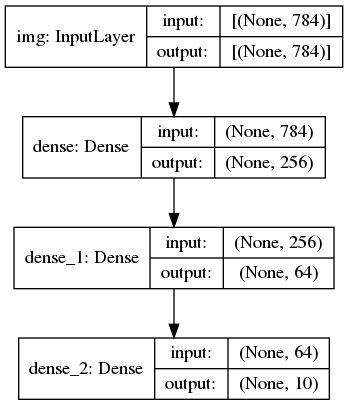

In [5]:
keras.utils.plot_model(model, show_shapes=True)

Next step is compiling the model. Here is where we specify our loss function (categorical cross entropy as we're doing multi-class classification), our optimiser (we're using Adam, but there are a lot of others we could use listed [here](https://keras.io/optimizers/)), and any metrics we want to track.

Once the model is compiled, we call fit to train the model. Here is where we specify things like our batch size, and the number of epochs that we wish to train for.

In [6]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=20,
                    validation_split=0.2)

Epoch 1/20
750/750 [==============================] - 1s 1ms/step - loss: 0.6870 - accuracy: 0.7634 - val_loss: 0.4235 - val_accuracy: 0.8499
Epoch 2/20
750/750 [==============================] - 1s 984us/step - loss: 0.3813 - accuracy: 0.8621 - val_loss: 0.3629 - val_accuracy: 0.8673
Epoch 3/20
750/750 [==============================] - 1s 999us/step - loss: 0.3364 - accuracy: 0.8778 - val_loss: 0.3560 - val_accuracy: 0.8676
Epoch 4/20
750/750 [==============================] - 1s 980us/step - loss: 0.3138 - accuracy: 0.8831 - val_loss: 0.3241 - val_accuracy: 0.8814
Epoch 5/20
750/750 [==============================] - 1s 983us/step - loss: 0.2894 - accuracy: 0.8919 - val_loss: 0.3316 - val_accuracy: 0.8827
Epoch 6/20
750/750 [==============================] - 1s 982us/step - loss: 0.2738 - accuracy: 0.8976 - val_loss: 0.3394 - val_accuracy: 0.8772
Epoch 7/20
750/750 [==============================] - 1s 975us/step - loss: 0.2606 - accuracy: 0.9039 - val_loss: 0.3219 - val_accuracy: 0

Our model is now trained, so we can now evaluate the model. We'll use Keras' inbuilt evaluation function, and then also plot a confusion chart to have a look at what's going on. Becuase I can, we'll also print out some metrics using sklearn's `classificaiton_report`.

In [7]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

    print(classification_report(y_test, indexes))

313/313 - 0s - loss: 0.3828 - accuracy: 0.8830
Test loss: 0.38279277086257935
Test accuracy: 0.8830000162124634
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.78      0.80      1000
           3       0.90      0.87      0.89      1000
           4       0.76      0.85      0.80      1000
           5       0.98      0.95      0.96      1000
           6       0.69      0.68      0.68      1000
           7       0.95      0.95      0.95      1000
           8       0.99      0.97      0.98      1000
           9       0.94      0.97      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



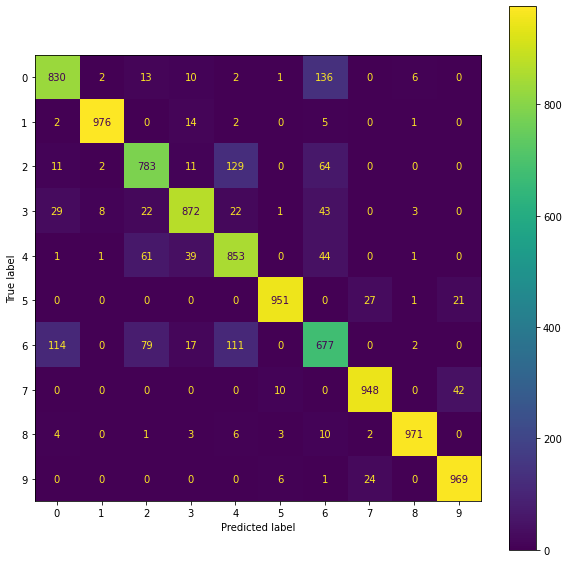

In [8]:
eval_model(model, x_test, y_test)

Our model works ok, but it's not great. Let's make it better.

## A CNN

We'll move to a CNN now and get this working better.
Given that we're going to use a CNN, we can use actual images, so we'll reload the data to get it back into the image shape that we want. Note that we also do a reshape on the data to get it into a 4D representation (samples, width, height, channels).

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

We'll build our model in much the same way as the first one, but just use different layers. Our key weapon here is the Conv2D (2D convolution) layer. We also have MaxPooling2D layers which are going to shrink our representation at various points throughout the network.

In [10]:
# our input now has a different shape, 28x28x1, as we have 28x28 single channel images
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
# rather than use a fully connected layer, we'll use 2D convolutional layers, 8 filters, 3x3 size kernels
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
# 2x2 max pooling, this will downsample the image by a factor of two
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# more convolution, 16 filters, followed by max poool
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# final convolution, 32 filters
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
# a flatten layer. Matlab does a flatten automatically, here we need to explicitly do this. Basically we're telling
# keras to make the current network state into a 1D shape so we can pass it into a fully connected layer
x = layers.Flatten()(x)
# a single fully connected layer, 64 inputs
x = layers.Dense(64, activation='relu')(x)
# and now our output, same as last time
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
model_cnn.summary()

Model: "fashion_mnist_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
flatten (Flatten)            (None, 288)   

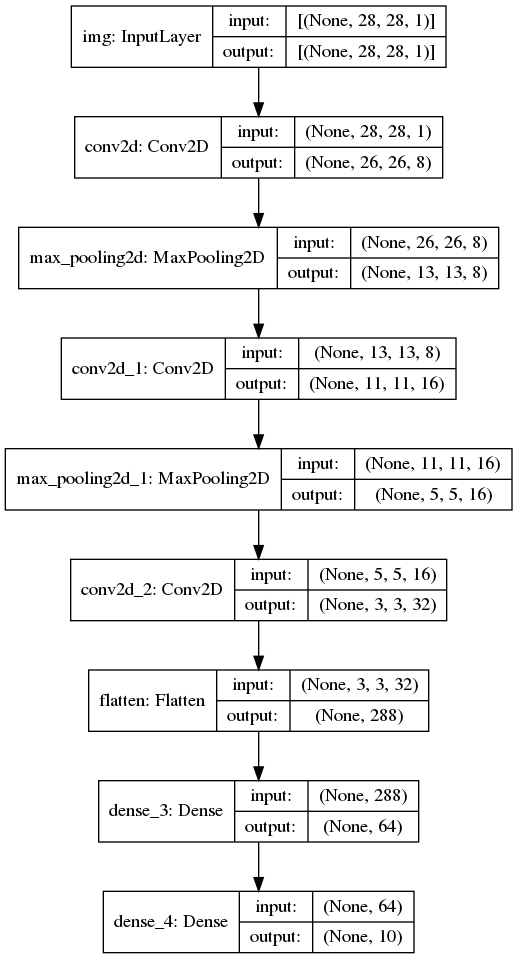

In [11]:
keras.utils.plot_model(model_cnn, show_shapes=True)

In [12]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2)

Epoch 1/20
750/750 [==============================] - 4s 3ms/step - loss: 1.0428 - accuracy: 0.6219 - val_loss: 0.5279 - val_accuracy: 0.8011
Epoch 2/20
750/750 [==============================] - 2s 3ms/step - loss: 0.5022 - accuracy: 0.8161 - val_loss: 0.4364 - val_accuracy: 0.8407
Epoch 3/20
750/750 [==============================] - 2s 3ms/step - loss: 0.4221 - accuracy: 0.8472 - val_loss: 0.3957 - val_accuracy: 0.8565
Epoch 4/20
750/750 [==============================] - 2s 3ms/step - loss: 0.3839 - accuracy: 0.8582 - val_loss: 0.3698 - val_accuracy: 0.8640
Epoch 5/20
750/750 [==============================] - 2s 3ms/step - loss: 0.3406 - accuracy: 0.8763 - val_loss: 0.3458 - val_accuracy: 0.8737
Epoch 6/20
750/750 [==============================] - 2s 2ms/step - loss: 0.3186 - accuracy: 0.8830 - val_loss: 0.3530 - val_accuracy: 0.8716
Epoch 7/20
750/750 [==============================] - 2s 3ms/step - loss: 0.3043 - accuracy: 0.8891 - val_loss: 0.3246 - val_accuracy: 0.8820
Epoch 

313/313 - 0s - loss: 0.3046 - accuracy: 0.8944
Test loss: 0.3046361207962036
Test accuracy: 0.8944000005722046
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.86      0.84      1000
           3       0.90      0.91      0.90      1000
           4       0.84      0.84      0.84      1000
           5       0.97      0.97      0.97      1000
           6       0.71      0.70      0.71      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



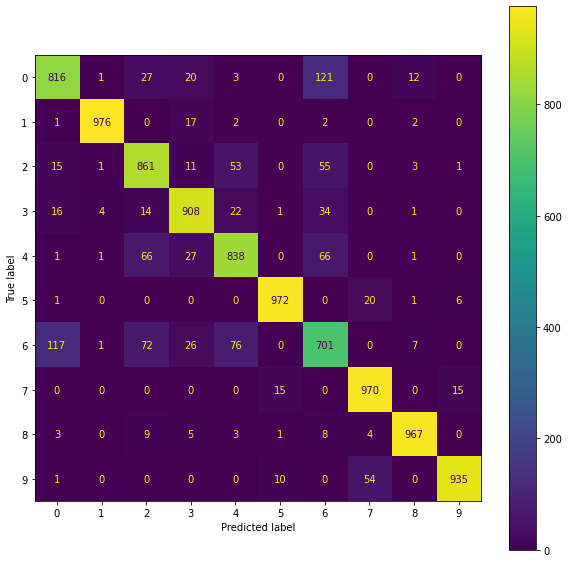

In [13]:
eval_model(model_cnn, x_test, y_test)

### SparseCategoricalCrossentropy(from_logits=False)?

We have the following above when we compile our network:

`model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])`
                  
What exactly are we doing here? Aren't we using regular categorical cross-entropy?

What we've done is taken a shortcut with our data wrangling. We have a 10 class problem, and so we have an output of size 10, where we expect the correct class to be set to 1, and all others 0 (a one-hot vector). Our target data though, is a list of numbers - i.e. we haven't converted it into a one-hot representation. Hence, we are using the `SparseCategoricalCrossentropy` loss which will do that conversion for us on the fly. If we had done the conversion, we would use regular `CategoricalCrossentropy`.

As for the `from_logits=False`, this comes down to whether we've applied a softmax layer or not at our output. If we haven't, then we'd set `from_logits=True` and again, our loss function would take care of the details for us and apply the softmax on the fly. For the sake of demonstration, we'll set the next model up with no softmax and use `from_logits=True`.

## Another Model
Let's crank it up a bit now. We'll add more convolutions, and add some batch norm and dropout (see `CAB420_DCNNs_Additional_Example_4_Layer_Order_and_Overfitting.ipynb` for details on those). Note that some of the dropout is not really needed here (we're not particularly overfitting), but for demonstration purposes it is included.

We'll also fire up tensorboard to get some slightly nicer visuals of model training and the like. Note that for (probably) the rest of the examples I'm not going to use tensorboard that much. This is not out of any dislike of it, but rather down to my own workflow of sync'ing examples to the clound and version control, and the fact that I chop and change between Linux and Windows on different systems - and basically wanting to avoid issues that come with my (eratic) workflow.

In [14]:
%load_ext tensorboard

# our model, input again, still in an image shape
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
# run pairs of conv layers, all 3s3 kernels
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
# batch normalisation, before the non-linearity
x = layers.BatchNormalization()(x)
# spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
# than dropping out 20% of the invidual pixels
x = layers.SpatialDropout2D(0.2)(x)
# max pooling, 2x2, which will downsample the image
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# rinse and repeat with 2D convs, batch norm, dropout and max pool
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# final conv2d, batch norm and spatial dropout
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
# flatten layer
x = layers.Flatten()(x)
# we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
# in the middle
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
# the output
outputs = layers.Dense(10, activation=None)(x)

# build the model, and print a summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
model_cnn.summary()

Model: "fashion_mnist_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14,

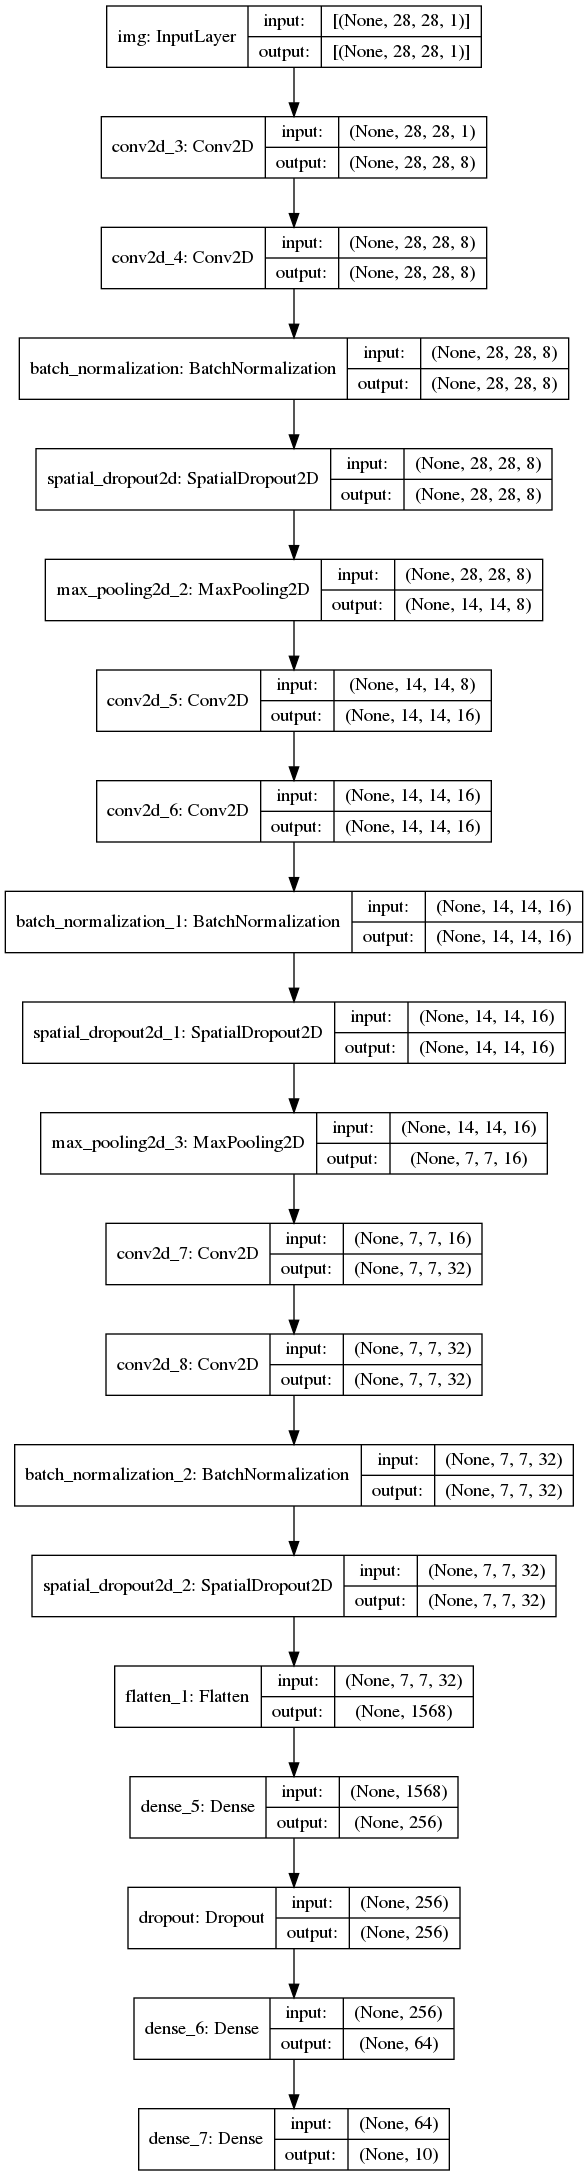

In [15]:
keras.utils.plot_model(model_cnn, show_shapes=True)

Start tensorboard. We'll also create a directory to store logs, and a callback so that we get our model training to push data to tensorboard.

In [16]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
%tensorboard --logdir logs

Compile and train the model

In [17]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2,
                        callbacks=[tensorboard_callback])

Epoch 1/20
750/750 [==============================] - 5s 6ms/step - loss: 0.8952 - accuracy: 0.6888 - val_loss: 0.4061 - val_accuracy: 0.8503
Epoch 2/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4725 - accuracy: 0.8332 - val_loss: 0.3447 - val_accuracy: 0.8648
Epoch 3/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4139 - accuracy: 0.8532 - val_loss: 0.3354 - val_accuracy: 0.8770
Epoch 4/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3965 - accuracy: 0.8640 - val_loss: 0.2948 - val_accuracy: 0.8914
Epoch 5/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3709 - accuracy: 0.8694 - val_loss: 0.3028 - val_accuracy: 0.8983
Epoch 6/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3558 - accuracy: 0.8779 - val_loss: 0.3072 - val_accuracy: 0.8855
Epoch 7/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3501 - accuracy: 0.8771 - val_loss: 0.2749 - val_accuracy: 0.8993
Epoch 

313/313 - 1s - loss: 0.2621 - accuracy: 0.9120
Test loss: 0.26205945014953613
Test accuracy: 0.9120000004768372
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.91      0.83      0.87      1000
           3       0.89      0.93      0.91      1000
           4       0.81      0.90      0.85      1000
           5       0.98      0.98      0.98      1000
           6       0.77      0.71      0.74      1000
           7       0.95      0.98      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



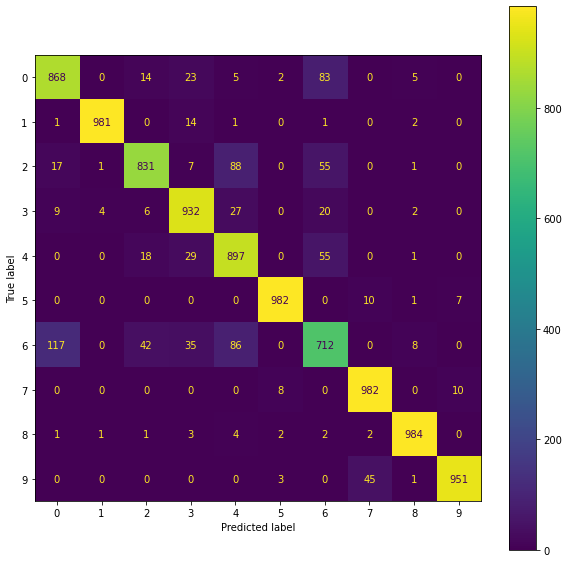

In [18]:
eval_model(model_cnn, x_test, y_test)

Our final model is working a bit better again, but it is a lot bigger. It's worth noting the size increase here and the performance gain (or lack of) that goes with it. 

With DCNNs there are very much some diminishing returns going on. We can make our networks bigger and bigger, and while they will get better, the rate of improvement is really quite small compared to the increase in complexity that comes with it.

## Final Thoughts

In this example we've seen:
* How to train a deep neural network
* The difference between a simple fully connected feed-forward network, and a convolutional network
* How convoluational layers can be 'stacked' to increase computation power
* That deep networks aren't fast to train

Note that, as is often the case, we've not really used a validation set. Rather we've trained for a fixed number of epochs and stopped at that point. The other approach with deep nets is to, using a validation set, train for a fixed number of epochs and take the best performing set across all epochs on the validation set, and apply that model to the test set. This guards against overfitting as if the network starts to overfit and performance on the validation set drops, we end up taking the version of the network that performed best on the validation network before things overfit. This is actually really easy to do in Keras with a [callback](https://keras.io/callbacks/#modelcheckpoint) if you so wish.

Note also that we haven't really trained to convergence either. We could afford to let these models run longer, which we can easily do by increasing the number of epochs. The only real reason I haven't done this is for the sake of run-times.